# 異常検知
単純な統計量から異常が含まれる区間を見つけられるか試してみます。

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.datasets import make_regression

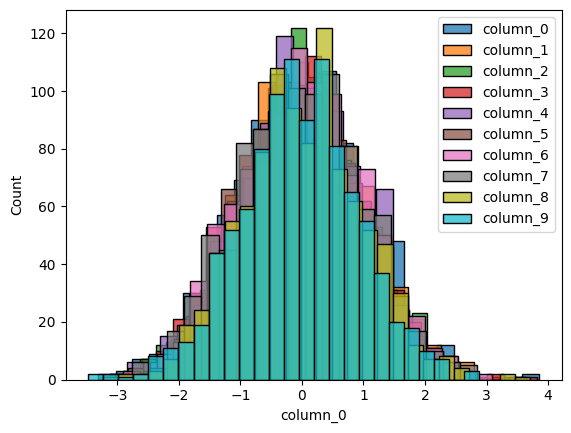

<Axes: >

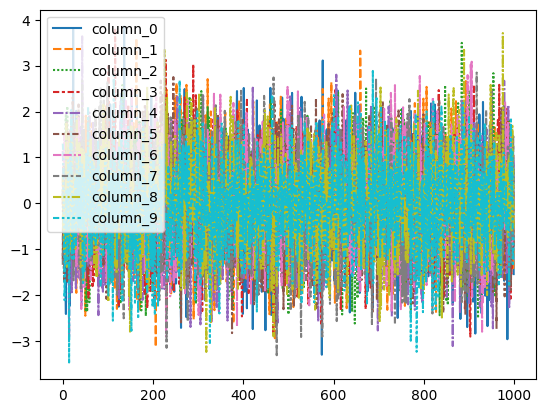

In [2]:
X, y = make_regression(
    n_samples=1000,
    n_features=10,
    noise=1,
    random_state=117117,
    n_informative=8,
    tail_strength=0.1,
)
df = pd.DataFrame(X)
df.columns = [f"column_{i}" for i in df.columns]

for c in df.columns:
    sns.histplot(data=df, x=c, label=c)

plt.legend()
plt.show()


sns.lineplot(data=df)

In [3]:
split_index = [0, 100, 300, 500, 800, 1000]
split_index.sort(reverse=True)

# column_1 のみ全体のデータを0.1だけ増やす＝異常なデータが含まれる区間
df.iloc[300:500, 0] += 0.1

def get_span_idx(i, split_index=split_index):
    for j, sj in enumerate(split_index):
        if i > sj - 1:
            return j


df["label"] = [get_span_idx(i, split_index=split_index) for i in df.index]

In [4]:
agg_info = {
    colname: [
        "min",
        "max",
        "median",
        "std",
        #"var",
        #"skew",
        #pd.NamedAgg(column="-3sigma", aggfunc=lambda c: c.quantile(0.015)),
        pd.NamedAgg(column="-2sigma", aggfunc=lambda c: c.quantile(0.0225)),
        #pd.NamedAgg(column="-1sigma", aggfunc=lambda c: c.quantile(0.1585)),
        #pd.NamedAgg(column="+1sigma", aggfunc=lambda c: c.quantile(1 - 0.1585)),
        pd.NamedAgg(column="+2sigma", aggfunc=lambda c: c.quantile(1 - 0.0225)),
        #pd.NamedAgg(column="+3sigma", aggfunc=lambda c: c.quantile(1 - 0.015)),
    ]
    for colname in df.select_dtypes("number").columns if not "label" in colname
}

stats = df.groupby("label").agg(agg_info)

stats

column_0                                                    column_1  \
            min       max    median       std   -2sigma   +2sigma       min   
label                                                                         
1     -2.964999  2.208448 -0.172032  1.040522 -2.463769  1.790024 -2.399068   
2     -3.302814  3.112490 -0.030690  1.030120 -1.895396  2.006561 -2.324959   
3     -2.668354  2.615554  0.058161  1.034144 -2.101008  2.207252 -2.983098   
4     -2.717002  3.854101 -0.070535  1.092459 -1.913490  2.321437 -3.132430   
5     -2.414786  3.792022  0.124725  1.028677 -1.728208  1.760964 -2.453160   

                                     ...  column_8                      \
            max    median       std  ...    median       std   -2sigma   
label                                ...                                 
1      2.665077  0.107903  0.957339  ...  0.170102  1.013858 -1.670121   
2      3.327802 -0.016651  0.978235  ... -0.115018  0.944461 -1.984532   
3      2.706210  0.021226  1.043956  ... -0.010817  1.001526 -1.899754   
4      3.601752 -0.140674  1.064319  ...  0.032695  1.002786 -1.885556   
5      2.116486 -0.109561  0.924774  ...  0.051282  0.905856 -1.550149   

                 column_9                                                    
        +2sigma       min       max    median       std   -2sigma   +2sigma  
label                                                                        
1      2.320933 -2.350403  2.217425 -0.016988  0.921249 -1.747335  1.868235  
2      1.617021 -3.239138  2.884228 -0.005554  0.998736 -1.987965  1.982874  
3      1.961405 -3.047778  2.371806 -0.105464  0.868754 -1.685387  1.586645  
4      2.129623 -2.781988  2.788289 -0.046750  1.012668 -2.262725  1.717820  
5      1.735964 -3.471808  2.107930 -0.215036  0.935209 -1.793050  1.350002  

[5 rows x 60 columns]

In [5]:
stats.reset_index()

label  column_0                                                    column_1  \
              min       max    median       std   -2sigma   +2sigma       min   
0     1 -2.964999  2.208448 -0.172032  1.040522 -2.463769  1.790024 -2.399068   
1     2 -3.302814  3.112490 -0.030690  1.030120 -1.895396  2.006561 -2.324959   
2     3 -2.668354  2.615554  0.058161  1.034144 -2.101008  2.207252 -2.983098   
3     4 -2.717002  3.854101 -0.070535  1.092459 -1.913490  2.321437 -3.132430   
4     5 -2.414786  3.792022  0.124725  1.028677 -1.728208  1.760964 -2.453160   

                       ...  column_8                                column_9  \
        max    median  ...    median       std   -2sigma   +2sigma       min   
0  2.665077  0.107903  ...  0.170102  1.013858 -1.670121  2.320933 -2.350403   
1  3.327802 -0.016651  ... -0.115018  0.944461 -1.984532  1.617021 -3.239138   
2  2.706210  0.021226  ... -0.010817  1.001526 -1.899754  1.961405 -3.047778   
3  3.601752 -0.140674  ...  0.032695  1.002786 -1.885556  2.129623 -2.781988   
4  2.116486 -0.109561  ...  0.051282  0.905856 -1.550149  1.735964 -3.471808   

                                                     
        max    median       std   -2sigma   +2sigma  
0  2.217425 -0.016988  0.921249 -1.747335  1.868235  
1  2.884228 -0.005554  0.998736 -1.987965  1.982874  
2  2.371806 -0.105464  0.868754 -1.685387  1.586645  
3  2.788289 -0.046750  1.012668 -2.262725  1.717820  
4  2.107930 -0.215036  0.935209 -1.793050  1.350002  

[5 rows x 61 columns]